# Pig Detection CNN Project

This notebook scaffolds the workflow for the HW1 dense pig detection assignment.

## Project Setup

In [1]:
import os
import json
import math
import random
from pathlib import Path

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


In [2]:
# adjust experiment metadata
EXPERIMENT_NAME = "pig_detection_baseline"
OUTPUT_DIR = Path("artifacts") / EXPERIMENT_NAME
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# configure dataset root and annotation paths
DATA_ROOT = Path("../../../taica-cvpdl-2025-hw-1/")
ANNOTATIONS_PATH = DATA_ROOT / "train/gt.txt"
IMAGES_DIR = DATA_ROOT / "train/img"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# ### TODO ###: choose an appropriate seed value
set_seed(42)


## Data Pipeline

In [4]:
class PigDetectionDataset(Dataset):
    def __init__(self, annotations, images_dir: Path, transforms=None):
        self.annotations = annotations
        self.images_dir = Path(images_dir)
        self.transforms = transforms

    @classmethod
    def from_txt(cls, annotations_path: Path, images_dir: Path, transforms=None):
        annotations_path = Path(annotations_path)
        images_dir = Path(images_dir)
        annotations_by_frame: dict[int, list[list[float]]] = {}

        with open(annotations_path, "r") as fp:
            for line in fp:
                stripped = line.strip()
                if not stripped:
                    continue
                parts = stripped.split(",")
                if len(parts) < 5:
                    continue
                frame_id = int(parts[0])
                bbox = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                annotations_by_frame.setdefault(frame_id, []).append(bbox)

        records = []
        skipped_frames = []
        for frame_id in sorted(annotations_by_frame.keys()):
            file_name = f"{frame_id:08d}.jpg"
            image_path = images_dir / file_name
            if not image_path.exists():
                skipped_frames.append(file_name)
                continue
            records.append(
                {
                    "image_id": frame_id,
                    "file_name": file_name,
                    "boxes": annotations_by_frame[frame_id],
                    "labels": [1] * len(annotations_by_frame[frame_id]),
                }
            )

        if skipped_frames:
            print(
                f"Warning: skipped {len(skipped_frames)} annotation entries with missing images."
            )

        return cls(records, images_dir, transforms)

    def __len__(self) -> int:
        return len(self.annotations)

    def __getitem__(self, idx: int):
        record = self.annotations[idx]
        image_path = self.images_dir / record["file_name"]
        image = Image.open(image_path).convert("RGB")
        image = torch.as_tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

        boxes = torch.as_tensor(record["boxes"], dtype=torch.float32)
        labels = torch.as_tensor(record["labels"], dtype=torch.long)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(record["image_id"], dtype=torch.long),
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


train_transforms = None
val_transforms = None


In [5]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [img if torch.is_tensor(img) else torch.as_tensor(img, dtype=torch.float32) for img in images]
    return list(images), list(targets)


def create_dataloaders(
    batch_size: int = 4,
    num_workers: int = 0,
    val_ratio: float = 0.2,
    seed: int = 42,
):
    """Create train/validation dataloaders with a deterministic split."""
    base_dataset = PigDetectionDataset.from_txt(
        ANNOTATIONS_PATH,
        IMAGES_DIR,
        transforms=None,
    )

    num_samples = len(base_dataset)
    if num_samples == 0:
        raise ValueError("Dataset is empty; check annotation and image paths.")

    indices = list(range(num_samples))
    random.Random(seed).shuffle(indices)

    val_size = max(1, int(num_samples * val_ratio))
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    train_annotations = [base_dataset.annotations[i] for i in train_indices]
    val_annotations = [base_dataset.annotations[i] for i in val_indices]

    train_dataset = PigDetectionDataset(
        train_annotations,
        IMAGES_DIR,
        transforms=train_transforms,
    )
    val_dataset = PigDetectionDataset(
        val_annotations,
        IMAGES_DIR,
        transforms=val_transforms,
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    return train_loader, val_loader


train_loader, val_loader = create_dataloaders(batch_size=4, num_workers=0, val_ratio=0.2, seed=42)


## Model Definition

In [6]:
class PigDetectionModel(nn.Module):
    def __init__(self, in_channels: int = 3, grid_size: tuple[int, int] = (4, 4)):
        super().__init__()
        # Three-layer CNN backbone
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.grid_size = grid_size
        self.global_pool = nn.AdaptiveAvgPool2d(self.grid_size)
        self.num_predictions = self.grid_size[0] * self.grid_size[1]
        # Fully connected detection head outputs (left, top, width, height, confidence) per grid cell
        self.head = nn.Linear(128 * self.num_predictions, self.num_predictions * 5)
        # ### TODO ###: adjust `grid_size` (and therefore `num_predictions`) to control proposal count per image

    def forward(self, images, targets=None):
        if isinstance(images, (list, tuple)):
            images = torch.stack(images)
        features = self.feature_extractor(images)
        pooled = self.global_pool(features)
        flattened = pooled.view(pooled.size(0), -1)
        predictions = self.head(flattened)
        predictions = predictions.view(images.size(0), self.num_predictions, 5)
        box_preds = predictions[..., :4]
        cls_logits = predictions[..., 4]
        return {"pred_boxes": box_preds, "pred_logits": cls_logits}


def build_model() -> PigDetectionModel:
    model = PigDetectionModel()
    return model.to(DEVICE)


model = build_model()
print(model)


PigDetectionModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (head): Linear(in_features=2048, out_features=80, bias=True)
)


In [7]:
def _ensure_tensor(data, *, dtype, device):
    if data is None:
        return torch.empty((0,), dtype=dtype, device=device)
    if torch.is_tensor(data):
        tensor = data.to(device=device, dtype=dtype)
    else:
        tensor = torch.as_tensor(data, dtype=dtype, device=device)
    if tensor.ndim == 1 and dtype is torch.float32:
        tensor = tensor.unsqueeze(0)
    return tensor


def _ltwh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    left_top = boxes[..., :2]
    wh = torch.clamp(boxes[..., 2:], min=0.0)
    right_bottom = left_top + wh
    return torch.cat([left_top, right_bottom], dim=-1)


def _box_iou_matrix(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return boxes1.new_zeros((boxes1.size(0), boxes2.size(0)))
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]
    area1 = ((boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0))
    area2 = ((boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0))
    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def _match_predictions(pred_boxes, gt_boxes, scores, iou_threshold: float = 0.5):
    if pred_boxes.numel() == 0 or gt_boxes.numel() == 0:
        return [], [], []
    order = torch.argsort(scores, descending=True)
    matched_gt = torch.zeros(gt_boxes.size(0), dtype=torch.bool, device=pred_boxes.device)
    matched_pred_indices = []
    matched_gt_indices = []
    matched_ious = []
    for idx in order:
        ious = _box_iou_matrix(pred_boxes[idx].unsqueeze(0), gt_boxes).squeeze(0)
        best_iou, best_gt = ious.max(0)
        if best_iou >= iou_threshold and not matched_gt[best_gt]:
            matched_gt[best_gt] = True
            matched_pred_indices.append(idx.item())
            matched_gt_indices.append(best_gt.item())
            matched_ious.append(best_iou.item())
    return matched_pred_indices, matched_gt_indices, matched_ious


# ### TODO ###: define your loss function(s) and metrics
def compute_loss(outputs, targets, iou_threshold: float = 0.5):
    pred_boxes_raw = outputs["pred_boxes"]
    pred_logits = outputs["pred_logits"]

    bbox_losses = []
    cls_losses = []

    for pred_boxes_img, logits_img, target in zip(pred_boxes_raw, pred_logits, targets):
        device = pred_boxes_img.device
        gt_boxes = _ensure_tensor(target.get("boxes"), dtype=torch.float32, device=device)
        if gt_boxes.numel() > 0:
            if gt_boxes.size(-1) == 4 and torch.any(gt_boxes[:, 2] > gt_boxes[:, 0]):
                widths = gt_boxes[:, 2] - gt_boxes[:, 0]
                heights = gt_boxes[:, 3] - gt_boxes[:, 1]
                if torch.all(widths >= 0) and torch.all(heights >= 0):
                    gt_boxes = torch.stack((gt_boxes[:, 0], gt_boxes[:, 1], widths, heights), dim=-1)
        else:
            gt_boxes = gt_boxes.view(0, 4)

        left_top = pred_boxes_img[..., :2]
        wh = F.softplus(pred_boxes_img[..., 2:])
        pred_boxes = torch.cat([left_top, wh], dim=-1)

        num_preds = pred_boxes.size(0)
        cls_labels = torch.zeros(num_preds, dtype=torch.long, device=device)

        if gt_boxes.numel() > 0:
            gt_boxes = gt_boxes.to(device)
            pred_xyxy = _ltwh_to_xyxy(pred_boxes)
            gt_xyxy = _ltwh_to_xyxy(gt_boxes)
            matched_pred_idx, matched_gt_idx, _ = _match_predictions(pred_xyxy, gt_xyxy, torch.sigmoid(logits_img), iou_threshold)

            if matched_pred_idx:
                matched_pred_tensor = torch.tensor(matched_pred_idx, dtype=torch.long, device=device)
                matched_gt_tensor = torch.tensor(matched_gt_idx, dtype=torch.long, device=device)
                target_boxes_matched = gt_boxes[matched_gt_tensor]
                bbox_loss = F.smooth_l1_loss(pred_boxes[matched_pred_tensor], target_boxes_matched, reduction="mean")
                cls_labels[matched_pred_tensor] = 1
            else:
                bbox_loss = torch.tensor(0.0, device=device)
        else:
            bbox_loss = torch.tensor(0.0, device=device)

        classification_logits = torch.stack([torch.zeros_like(logits_img), logits_img], dim=-1)
        classification_loss = F.cross_entropy(classification_logits, cls_labels, reduction="mean")

        bbox_losses.append(bbox_loss)
        cls_losses.append(classification_loss)

    total_bbox_loss = torch.stack(bbox_losses).mean() if bbox_losses else torch.tensor(0.0, device=DEVICE)
    total_cls_loss = torch.stack(cls_losses).mean() if cls_losses else torch.tensor(0.0, device=DEVICE)
    return total_bbox_loss + total_cls_loss


def _average_precision(pred_boxes, scores, gt_boxes, iou_threshold: float) -> float:
    if gt_boxes.numel() == 0:
        return 0.0
    if pred_boxes.numel() == 0:
        return 0.0
    order = torch.argsort(scores, descending=True)
    pred_boxes = pred_boxes[order]
    scores = scores[order]

    tp = torch.zeros(pred_boxes.size(0), dtype=torch.float32)
    fp = torch.zeros_like(tp)
    matched_gt = torch.zeros(gt_boxes.size(0), dtype=torch.bool)

    for i, box in enumerate(pred_boxes):
        ious = _box_iou_matrix(box.unsqueeze(0), gt_boxes).squeeze(0)
        max_iou, max_idx = ious.max(0)
        if max_iou >= iou_threshold and not matched_gt[max_idx]:
            tp[i] = 1.0
            matched_gt[max_idx] = True
        else:
            fp[i] = 1.0

    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)
    recalls = tp_cum / (gt_boxes.size(0) + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    precisions = torch.cat([torch.tensor([0.0]), precisions, torch.tensor([0.0])])
    recalls = torch.cat([torch.tensor([0.0]), recalls, torch.tensor([1.0])])

    for i in range(precisions.size(0) - 1, 0, -1):
        precisions[i - 1] = torch.maximum(precisions[i - 1], precisions[i])

    indices = torch.where(recalls[1:] != recalls[:-1])[0]
    ap = torch.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return float(ap.item())


# ### TODO ###: add metric computations (mAP, IoU, etc.)
def compute_metrics(outputs, targets):
    pred_boxes_raw = outputs["pred_boxes"].detach()
    pred_logits = outputs["pred_logits"].detach()

    left_top = pred_boxes_raw[..., :2]
    wh = F.softplus(pred_boxes_raw[..., 2:])
    pred_boxes = torch.cat([left_top, wh], dim=-1)
    pred_xyxy = _ltwh_to_xyxy(pred_boxes)
    pred_scores = torch.sigmoid(pred_logits)

    iou_thresholds = torch.arange(0.5, 1.0, 0.05)
    ap_totals = torch.zeros_like(iou_thresholds)
    image_count = 0
    iou_accumulator = 0.0
    iou_match_count = 0

    for boxes_img, scores_img, xyxy_img, target in zip(pred_boxes, pred_scores, pred_xyxy, targets):
        device = boxes_img.device
        gt_boxes = _ensure_tensor(target.get("boxes"), dtype=torch.float32, device=device)
        if gt_boxes.numel() > 0:
            if gt_boxes.size(-1) == 4 and torch.any(gt_boxes[:, 2] > gt_boxes[:, 0]):
                widths = gt_boxes[:, 2] - gt_boxes[:, 0]
                heights = gt_boxes[:, 3] - gt_boxes[:, 1]
                if torch.all(widths >= 0) and torch.all(heights >= 0):
                    gt_boxes = torch.stack((gt_boxes[:, 0], gt_boxes[:, 1], widths, heights), dim=-1)
        else:
            gt_boxes = gt_boxes.view(0, 4)

        gt_xyxy = _ltwh_to_xyxy(gt_boxes)

        aps = []
        for thr in iou_thresholds:
            ap = _average_precision(xyxy_img, scores_img, gt_xyxy, float(thr.item()))
            aps.append(ap)
        ap_totals += torch.tensor(aps)
        image_count += 1

        matched_pred_idx, matched_gt_idx, matched_ious = _match_predictions(xyxy_img, gt_xyxy, scores_img, 0.5)
        if matched_ious:
            iou_accumulator += float(sum(matched_ious) / len(matched_ious))
            iou_match_count += 1

    mean_ap = float((ap_totals / max(image_count, 1)).mean().item()) if image_count > 0 else 0.0
    metrics = {
        "mAP@0.5:0.95": mean_ap,
    }

    if image_count > 0:
        for thr, total in zip(iou_thresholds, ap_totals):
            metrics[f"AP@{thr.item():.2f}"] = float(total.item() / max(image_count, 1))

    if iou_match_count > 0:
        metrics["IoU_mean"] = iou_accumulator / iou_match_count
    else:
        metrics["IoU_mean"] = 0.0

    return metrics


## Optimization

In [8]:
# ### TODO ###: configure optimizer, LR scheduler, and training hyperparameters
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 1

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = None  # ### TODO ###: optionally add LR scheduler


## Training Loop

In [9]:
def _prepare_batch(images, targets):
    processed_images = []
    processed_targets = []
    for img, tgt in zip(images, targets):
        if not torch.is_tensor(img):
            img = torch.as_tensor(img, dtype=torch.float32)
        # normalize to [0,1] assumed preprocessed externally if needed
        processed_images.append(img.to(DEVICE))

        processed_target = {}
        if isinstance(tgt, dict):
            for key, value in tgt.items():
                if torch.is_tensor(value):
                    processed_target[key] = value.to(DEVICE)
                else:
                    processed_target[key] = value
        processed_targets.append(processed_target)
    batch_images = torch.stack(processed_images)
    return batch_images, processed_targets


def train_one_epoch(model, dataloader, optimizer, log_interval: int = 10):
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(dataloader):
        images, targets = _prepare_batch(images, targets)

        outputs = model(images, targets)
        loss = compute_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step + 1) % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            print(f"step {step + 1}: loss={avg_loss:.4f}")
    return running_loss / max(1, len(dataloader))


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    eval_loss = 0.0
    metric_totals = {}
    batches = 0

    for images, targets in dataloader:
        images, targets = _prepare_batch(images, targets)

        outputs = model(images, targets)
        loss = compute_loss(outputs, targets)
        eval_loss += loss.item()

        metrics = compute_metrics(outputs, targets)
        for key, value in metrics.items():
            metric_totals[key] = metric_totals.get(key, 0.0) + float(value)
        batches += 1

    eval_loss /= max(1, batches)
    aggregated_metrics = {k: v / max(1, batches) for k, v in metric_totals.items()}
    return eval_loss, aggregated_metrics


In [10]:
def save_checkpoint(model, optimizer, epoch, best_metric=None):
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "best_metric": best_metric,
    }
    ckpt_path = OUTPUT_DIR / f"checkpoint_epoch_{epoch:03d}.pth"
    torch.save(checkpoint, ckpt_path)
    return ckpt_path

def load_checkpoint(model, optimizer, checkpoint_path: Path):
    state = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state["model_state"])
    optimizer.load_state_dict(state["optimizer_state"])
    return state


In [11]:
best_val_metric = None
no_improve_epochs = 0
patience = 5  # stop if no improvement for this many epochs
history = {"train_loss": [], "val_loss": [], "val_metrics": []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_metrics = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_metrics"].append(val_metrics)

    metric_str = ", ".join(f"{k}={v:.4f}" for k, v in val_metrics.items())
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, {metric_str}")

    if scheduler is not None:
        scheduler.step()

    current_metric = val_metrics.get("mAP@0.5:0.95", None)
    if current_metric is not None:
        if best_val_metric is None or current_metric > best_val_metric:
            best_val_metric = current_metric
            no_improve_epochs = 0
            best_path = OUTPUT_DIR / "best.pth"
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "best_metric": best_val_metric,
            }, best_path)
            print(f"Saved new best checkpoint to {best_path} (mAP@0.5:0.95={best_val_metric:.4f})")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping: no improvement in validation metric.")
                break
    save_checkpoint(model, optimizer, epoch, best_metric=best_val_metric)

history_path = OUTPUT_DIR / "history.json"
with open(history_path, "w") as fp:
    json.dump(history, fp, indent=2)
print(f"Training history saved to {history_path}")


step 10: loss=0.3059
step 20: loss=0.1530
step 30: loss=0.1020
step 40: loss=0.0765
step 50: loss=0.0612
step 60: loss=0.0510
step 70: loss=0.0437
step 80: loss=0.0382
step 90: loss=0.0340
step 100: loss=0.0306
step 110: loss=0.0278
step 120: loss=0.0255
step 130: loss=0.0235
step 140: loss=0.0219
step 150: loss=0.0204
step 160: loss=0.0191
step 170: loss=0.0180
step 180: loss=0.0170
step 190: loss=0.0161
step 200: loss=0.0153
step 210: loss=0.0146
step 220: loss=0.0139
step 230: loss=0.0133
step 240: loss=0.0127
step 250: loss=0.0122
Epoch 1: train_loss=0.0120, val_loss=0.0000, mAP@0.5:0.95=0.0000, AP@0.50=0.0000, AP@0.55=0.0000, AP@0.60=0.0000, AP@0.65=0.0000, AP@0.70=0.0000, AP@0.75=0.0000, AP@0.80=0.0000, AP@0.85=0.0000, AP@0.90=0.0000, AP@0.95=0.0000, IoU_mean=0.0000
Saved new best checkpoint to artifacts/pig_detection_baseline/best.pth (mAP@0.5:0.95=0.0000)
Training history saved to artifacts/pig_detection_baseline/history.json


In [ ]:



# with open(OUTPUT_DIR / "history.json", "r") as fp:
#     history_loaded = json.load(fp)
# plot_training_history(history_loaded)


## Evaluation & Visualization

Loaded checkpoint from artifacts/pig_detection_baseline/best.pth (epoch=1, best_metric=0.0)
Validation loss: 0.0000
  mAP@0.5:0.95: 0.0000
  AP@0.50: 0.0000
  AP@0.55: 0.0000
  AP@0.60: 0.0000
  AP@0.65: 0.0000
  AP@0.70: 0.0000
  AP@0.75: 0.0000
  AP@0.80: 0.0000
  AP@0.85: 0.0000
  AP@0.90: 0.0000
  AP@0.95: 0.0000
  IoU_mean: 0.0000


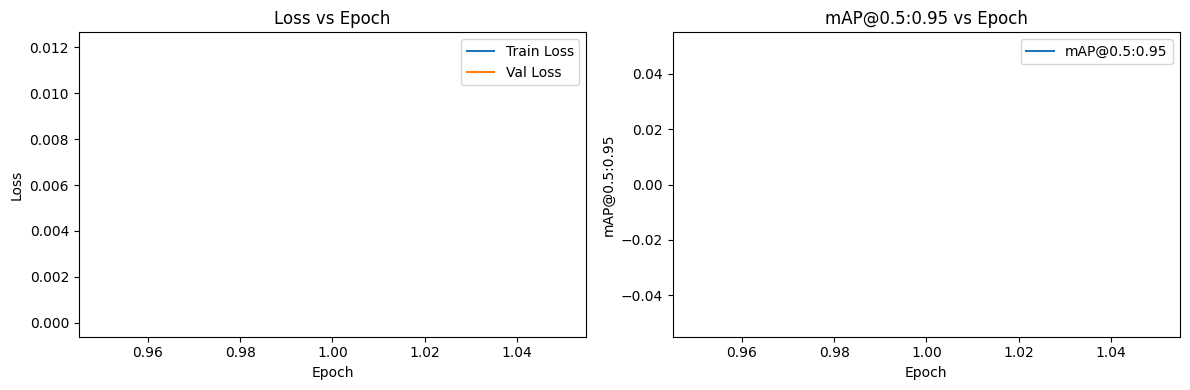

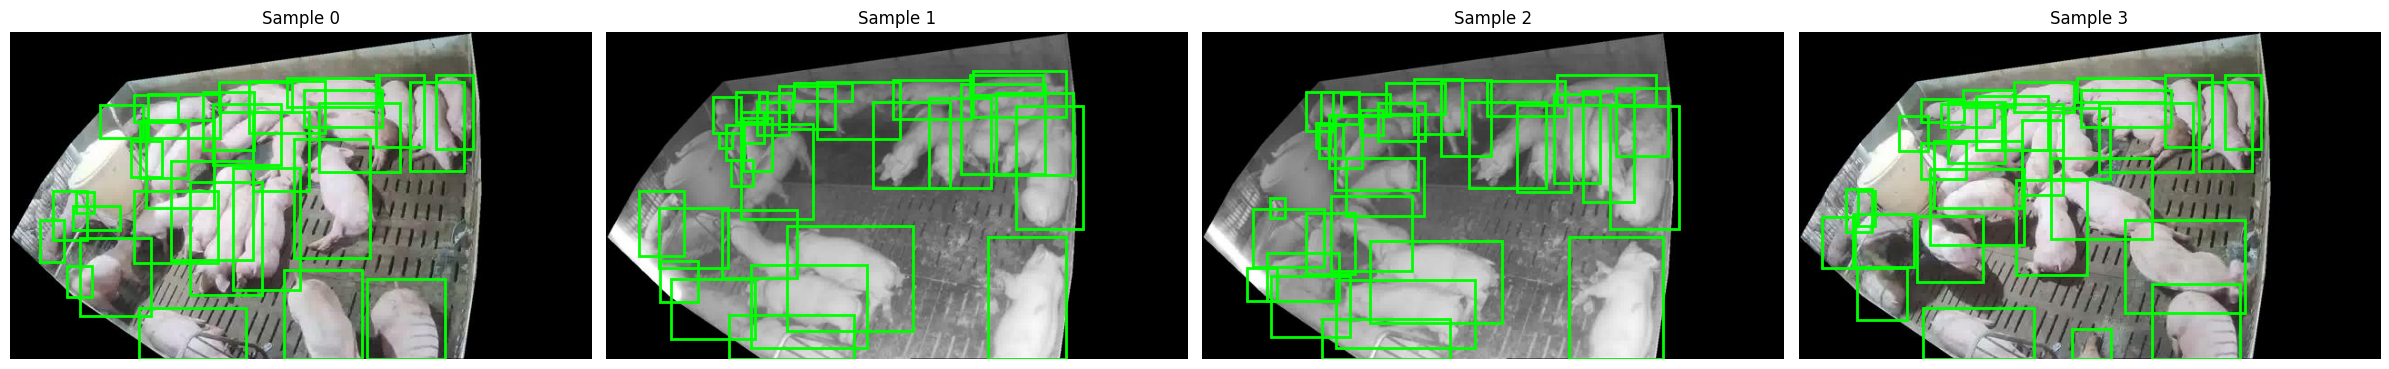

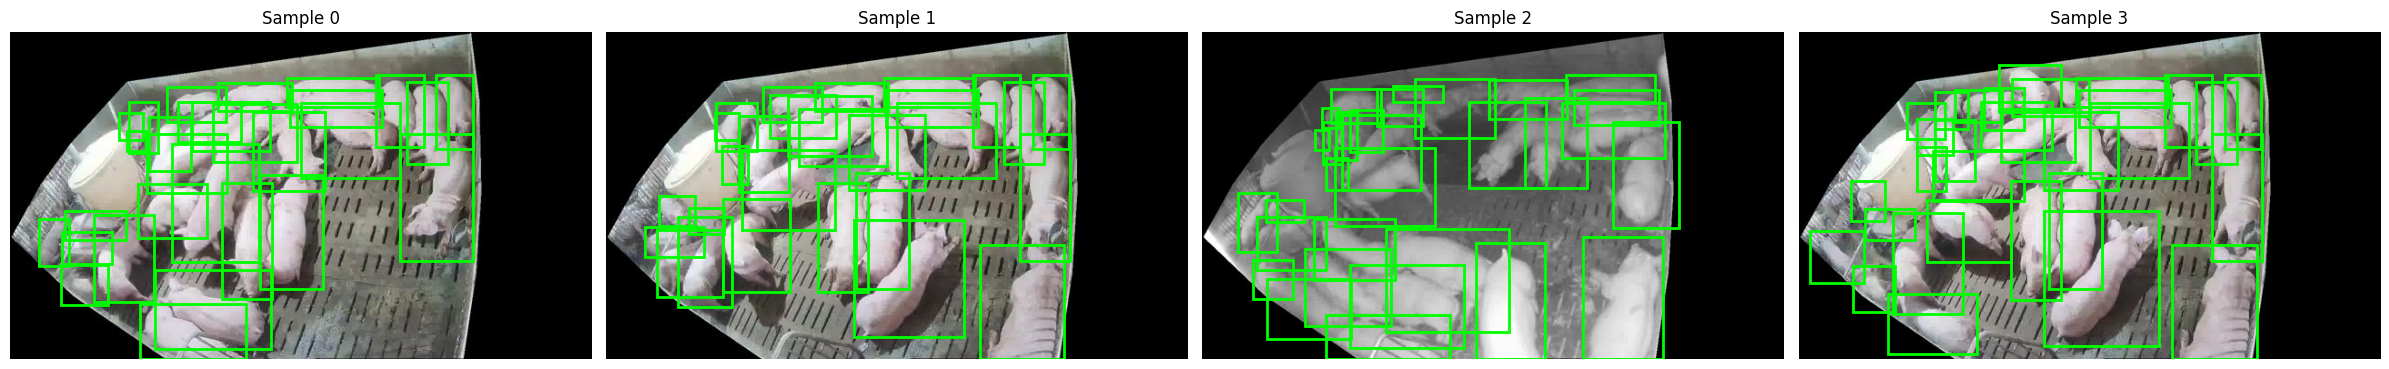

In [15]:
def plot_training_history(history_dict, metric_key: str = "mAP@0.5:0.95"):
    epochs = range(1, len(history_dict.get("train_loss", [])) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, history_dict.get("train_loss", []), label="Train Loss")
    axes[0].plot(epochs, history_dict.get("val_loss", []), label="Val Loss")
    axes[0].set_title("Loss vs Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    metric_values = [metrics.get(metric_key, 0.0) for metrics in history_dict.get("val_metrics", [])]
    axes[1].plot(epochs, metric_values, label=metric_key)
    axes[1].set_title(f"{metric_key} vs Epoch")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel(metric_key)
    axes[1].legend()

    plt.tight_layout()
    return fig


def _to_numpy_image(image_tensor):
    if torch.is_tensor(image_tensor):
        img = image_tensor.detach().cpu().float()
        if img.ndim == 2:
            img = img.unsqueeze(0)
        if img.ndim == 3:
            if img.max() > 1.0:
                img = img / 255.0
            img = img.clamp(0.0, 1.0)
            img = img.permute(1, 2, 0).numpy()
        else:
            raise ValueError("Image tensor must have 2 or 3 dimensions (CxHxW or HxW).")
    else:
        img = np.asarray(image_tensor)
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        if img.max() > 1.0:
            img = img / 255.0
    return img


def visualize_predictions(images, targets, outputs, score_threshold: float = 0.5, max_images: int = 4):
    pred_boxes_ltwh = outputs["pred_boxes"].detach().cpu()
    pred_scores = torch.sigmoid(outputs["pred_logits"].detach().cpu())
    pred_boxes_xyxy = _ltwh_to_xyxy(pred_boxes_ltwh)

    batch_size = min(pred_boxes_xyxy.size(0), max_images)
    fig, axes = plt.subplots(1, batch_size, figsize=(6 * batch_size, 6))
    if batch_size == 1:
        axes = [axes]

    for idx in range(batch_size):
        ax = axes[idx]
        img = _to_numpy_image(images[idx])
        ax.imshow(img)
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

        target = targets[idx]
        gt_boxes = target.get("boxes") if isinstance(target, dict) else None
        if gt_boxes is not None:
            if not torch.is_tensor(gt_boxes):
                gt_boxes = torch.as_tensor(gt_boxes, dtype=torch.float32)
            gt_boxes = gt_boxes.detach().cpu().float()
            if gt_boxes.numel() > 0:
                if gt_boxes.size(-1) == 4 and torch.any(gt_boxes[:, 2] > gt_boxes[:, 0]):
                    widths = gt_boxes[:, 2] - gt_boxes[:, 0]
                    heights = gt_boxes[:, 3] - gt_boxes[:, 1]
                    if torch.all(widths >= 0) and torch.all(heights >= 0):
                        gt_boxes = torch.stack((gt_boxes[:, 0], gt_boxes[:, 1], widths, heights), dim=-1)
                gt_boxes_xyxy = _ltwh_to_xyxy(gt_boxes)
                for box in gt_boxes_xyxy:
                    x1, y1, x2, y2 = box.tolist()
                    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="lime", facecolor="none")
                    ax.add_patch(rect)

        keep = pred_scores[idx] >= score_threshold
        for box, score in zip(pred_boxes_xyxy[idx][keep], pred_scores[idx][keep]):
            x1, y1, x2, y2 = box.tolist()
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none", linestyle="--")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=10, backgroundcolor="white")

    plt.tight_layout()
    return fig


def run_validation_and_visualization(
    model,
    dataloader,
    checkpoint_path: Path | None = None,
    visualize_batches: int = 1,
    score_threshold: float = 0.5,
):
    if checkpoint_path is not None and checkpoint_path.exists():
        state = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Loaded checkpoint from {checkpoint_path} (epoch={state.get('epoch')}, best_metric={state.get('best_metric')})")
    else:
        print("Using current model weights for evaluation.")

    val_loss, val_metrics = evaluate(model, dataloader)
    print(f"Validation loss: {val_loss:.4f}")
    for key, value in val_metrics.items():
        print(f"  {key}: {value:.4f}")

    if visualize_batches <= 0:
        return

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            prepared_images, prepared_targets = _prepare_batch(images, targets)
            outputs = model(prepared_images, prepared_targets)
            fig = visualize_predictions(images, targets, outputs, score_threshold=score_threshold)
            plt.show()
            if batch_idx + 1 >= visualize_batches:
                break

# Plot training history
with open(OUTPUT_DIR / "history.json", "r") as fp:
    history_loaded = json.load(fp)
plot_training_history(history_loaded)

# Visualize predictions on validation set
run_validation_and_visualization(model, val_loader, checkpoint_path=OUTPUT_DIR / "best.pth", visualize_batches=2, score_threshold=0.5)


## Inference

In [17]:
def _load_image_as_tensor(image):
    if isinstance(image, (str, Path)):
        image = Image.open(image).convert("RGB")
    if isinstance(image, Image.Image):
        image = np.array(image)
    if torch.is_tensor(image):
        img_tensor = image.clone().detach().float()
        if img_tensor.ndim == 3 and img_tensor.size(0) in (1, 3):
            if img_tensor.max() > 1.0:
                img_tensor = img_tensor / 255.0
        elif img_tensor.ndim == 3:
            img_tensor = img_tensor.permute(2, 0, 1).float() / 255.0
    else:
        img_tensor = torch.as_tensor(image).float()
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor / 255.0
    if img_tensor.ndim == 2:
        img_tensor = img_tensor.unsqueeze(0)
    if img_tensor.ndim != 3:
        raise ValueError("Image must be convertible to a CxHxW tensor.")
    if img_tensor.size(0) == 1:
        img_tensor = img_tensor.expand(3, -1, -1)
    return img_tensor.clamp(0.0, 1.0)


@torch.no_grad()
def run_inference(model, image, score_threshold: float = 0.5, max_detections: int | None = None):
    model.eval()
    image_tensor = _load_image_as_tensor(image)
    image_batch = image_tensor.unsqueeze(0).to(DEVICE)

    outputs = model(image_batch, targets=None)
    pred_boxes_raw = outputs["pred_boxes"].squeeze(0)
    pred_logits = outputs["pred_logits"].squeeze(0)

    left_top = pred_boxes_raw[..., :2]
    wh = F.softplus(pred_boxes_raw[..., 2:])
    boxes_ltwh = torch.cat([left_top, wh], dim=-1)
    scores = torch.sigmoid(pred_logits)

    keep = scores >= score_threshold
    boxes_ltwh = boxes_ltwh[keep]
    scores = scores[keep]

    if max_detections is not None and boxes_ltwh.size(0) > max_detections:
        topk = torch.topk(scores, max_detections)
        boxes_ltwh = boxes_ltwh[topk.indices]
        scores = topk.values

    boxes_xyxy = _ltwh_to_xyxy(boxes_ltwh)

    return {
        "boxes_ltwh": boxes_ltwh.cpu().numpy(),
        "boxes_xyxy": boxes_xyxy.cpu().numpy(),
        "scores": scores.cpu().numpy(),
    }


def format_detections_for_submission(detections, class_id: int = 0):
    boxes = detections["boxes_ltwh"]
    scores = detections["scores"]
    if boxes.size == 0:
        return ""
    parts = []
    for score, (left, top, width, height) in zip(scores, boxes):
        parts.append(
            f"{score:.6f} {left:.2f} {top:.2f} {width:.2f} {height:.2f} {class_id}"
        )
    return " ".join(parts)


@torch.no_grad()
def run_inference_on_directory(
    model,
    image_dir: Path,
    output_csv: Path | None = None,
    checkpoint_path: Path | None = None,
    score_threshold: float = 0.5,
    max_detections: int | None = None,
):
    image_dir = Path(image_dir)
    files = sorted(image_dir.glob("*.jpg"))
    if checkpoint_path is not None:
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint: epoch={state.get('epoch')}, best_metric={state.get('best_metric')}")

    rows = []
    for path in files:
        detections = run_inference(
            model,
            path,
            score_threshold=score_threshold,
            max_detections=max_detections,
        )
        image_id = path.stem.lstrip("0") or "0"
        prediction_string = format_detections_for_submission(detections)
        rows.append((image_id, prediction_string))

    if output_csv is not None:
        output_csv = Path(output_csv)
        output_csv.parent.mkdir(parents=True, exist_ok=True)
        with open(output_csv, "w") as fp:
            fp.write("Image_ID,PredictionString\n")
            for image_id, pred in rows:
                fp.write(f"{image_id},{pred}\n")
        print(f"Saved predictions to {output_csv}")

    return rows


# Example usage after training:
# run_inference_on_directory(
#     model,
#     image_dir=IMAGES_DIR,
#     output_csv=OUTPUT_DIR / "predictions.csv",
#     checkpoint_path=OUTPUT_DIR / "best.pth",
#     score_threshold=0.5,
#     max_detections=50,
# )


Loaded checkpoint from artifacts/pig_detection_baseline/best.pth


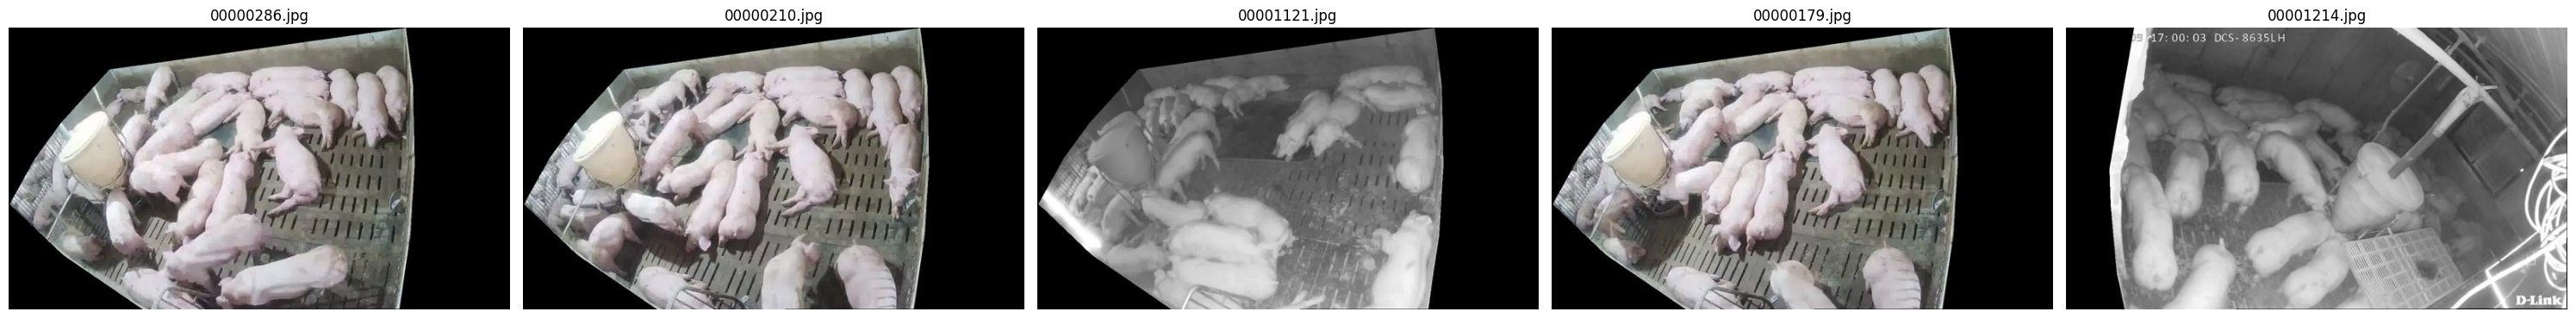

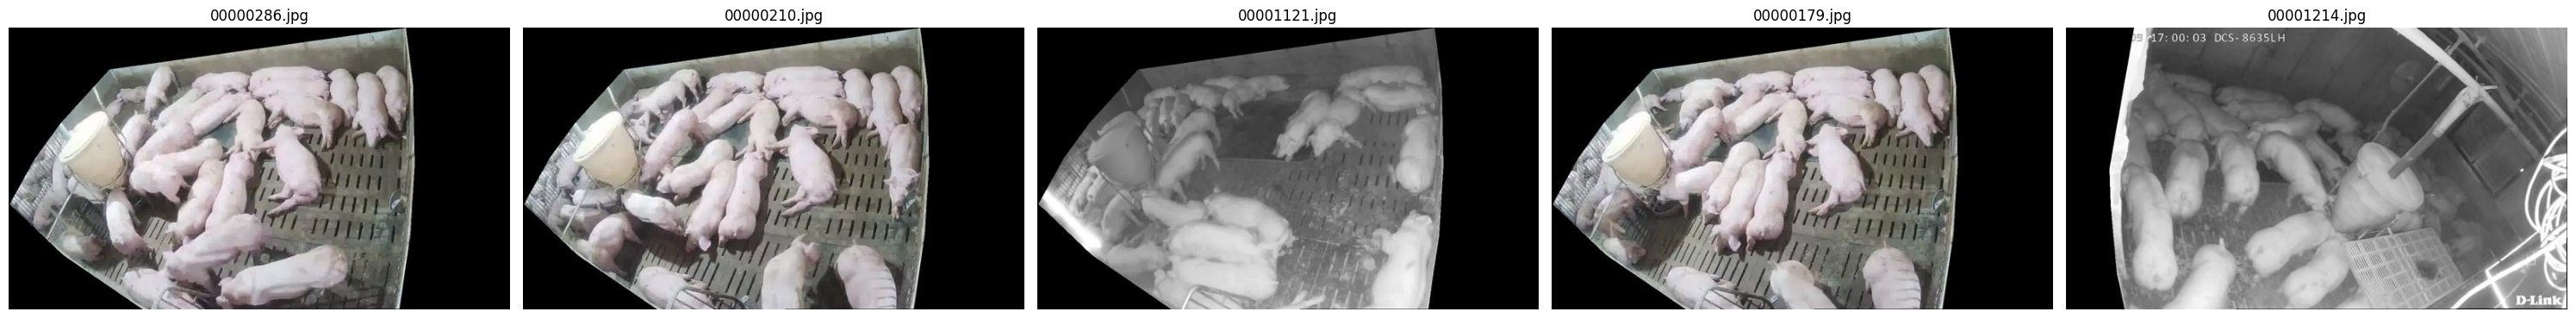

In [18]:
@torch.no_grad()
def visualize_random_predictions(
    model,
    image_dir: Path,
    num_images: int = 5,
    checkpoint_path: Path | None = None,
    score_threshold: float = 0.5,
    max_detections: int | None = 50,
):
    image_dir = Path(image_dir)
    image_paths = sorted(image_dir.glob("*.jpg"))
    if not image_paths:
        raise ValueError(f"No images found in {image_dir}")

    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))

    if checkpoint_path is not None and checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(state["model_state"])
        print(f"Loaded checkpoint from {checkpoint_path}")

    model.eval()
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(6 * len(sample_paths), 6))
    if len(sample_paths) == 1:
        axes = [axes]

    for ax, path in zip(axes, sample_paths):
        detections = run_inference(
            model,
            path,
            score_threshold=score_threshold,
            max_detections=max_detections,
        )
        image = Image.open(path).convert("RGB")
        ax.imshow(image)
        ax.set_title(path.name)
        ax.axis("off")

        boxes_xyxy = detections["boxes_xyxy"]
        scores = detections["scores"]
        for box, score in zip(boxes_xyxy, scores):
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color="red", fontsize=9, backgroundcolor="white")

    plt.tight_layout()
    plt.show()
    return fig


# Visualize random predictions from the trained model
visualize_random_predictions(
    model,
    image_dir=IMAGES_DIR,
    num_images=5,
    checkpoint_path=OUTPUT_DIR / "best.pth",
    score_threshold=0.5,
    max_detections=50,
)


## Next Steps

- Replace each `### TODO ###` with assignment-specific code for data parsing, model architecture, and evaluation.
- Add experiment tracking (TensorBoard, Weights & Biases, etc.) if desired.
- Integrate assignment-specific metrics and submission formatting.